This Jupyter notebook serves as a brief introduction to `ocean_qap`, a library designed to simplify Quadratic Assignment Problems (QAP) using D-Wave's Quantum SDK, Ocean. This library was built for [D-Wave's challenge at IQuHack 2025](https://github.com/iQuHACK/2025-D-Wave), and their formulation of the modified QAP will be useful in understanding this tutorial.

`ocean_qap` conveniently abstracts away many of the inner workings of time-dependent quadratic systems, allowing the user to easily initialize and evolve the state. We begin by importing all dependencies; please ensure you have the following libraries installed on your kernel: `dwave-ocean-sdk`, `numpy`, `matplotlib`, `networkx`, `ocean_qap`.

In [4]:
%pip install dwave-ocean-sdk
%pip install matplotlib
%pip install numpy
%pip install networkx
%pip install ocean_qap

199.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from dwave.samplers import SimulatedAnnealingSampler

154.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


160.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached matplotlib-3.10.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.8-cp313-cp313-macosx_10_13_universal2.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.0-cp313-cp313-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.55.8-cp313-cp313-macosx_10_13_universal2.whl (2.7 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-11.1.0-cp313-cp313-macosx_11_0_arm64.whl (3.1 MB)
Using cached pyparsing-3.2.1

167.59s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


173.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached dwave_ocean_sdk-8.1.0-py3-none-any.whl.metadata (5.5 kB)
  Using cached dimod-0.12.18-cp313-cp313-macosx_11_0_arm64.whl.metadata (4.0 kB)
  Using cached dwave_cloud_client-0.13.2-py3-none-any.whl.metadata (5.2 kB)
  Using cached dwave_gate-0.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (18 kB)
  Using cached dwave_hybrid-0.6.13-py3-none-any.whl.metadata (4.3 kB)
  Using cached dwave_inspector-0.5.2-py3-none-any.whl.metadata (4.4 kB)
  Using cached dwave_networkx-0.8.16-py3-none-any.whl.metadata (2.6 kB)
  Using cached dwave_optimization-0.4.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (18 kB)
  Using cached dwave_preprocessing-0.6.7-cp313-cp313-macosx_11_0_arm64.whl.metadata (3.6 kB)
  Using cached dwave_samplers-1.4.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.9 kB)
  Using cached dwave_system-1.28.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached dwavebinarycsp-0.3.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached minorminer-0.2.16-cp313-cp313-macosx_11_0_arm6

185.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


We're now ready to begin working with `ocean_qap`! The two primary inputs for the `QAP` class are a flow matrix and distance matrix, which must be initialized as numpy arrays. The QAP class, which represents the entire system described by these matrices and contains all of their inner workings, can then be initialized as follows:

In [6]:
from ocean_qap import QAP

flow_0 = np.array([[0, 0.5, 1], [0.5, 0, 10], [1, 10, 0]])
distance = np.array([[0, 105, 100], [105, 0, 10], [100, 10, 0]])
system = QAP(flow_0, distance)

The class automatically initializes various useful objects, such as the `qubo` object (representing a QUBO matrix for optimizing the system, generated from the flow and distance matrices). However, the state of the system has not yet been initialized, and must be done so as follows:

In [7]:
system.time_init()

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=int8)

Great! Behind the scenes, the `QAP` class has handled all aspects of initializing the system, including running a simulation to generate an optimized state based on the `qubo` object. You can access the current state of the system at any time from now with `system.cur_state`. This outputs a matrix of binary variables with the same dimension as your flow and distance matrices, where each entry $(i, j)$ represents whether or not facility $i$ is present at location $j$. Try it below:

In [8]:
print(system.cur_state)

[[1 0 0]
 [0 1 0]
 [0 0 1]]


Now you're ready to evolve this system. By using the `time_evolve()` method with a single parameter (a new flow matrix), we can evolve the system by generating a new state, which is now optimized not only using the flow and distance matrices, but on the cost associated with transitioning between the two states. Try it below:

In [9]:
flow_1 = np.array([[0, 10, 0.1], [10, 0, 100], [0.1, 100, 0]])
system.time_evolve(flow_1)
print(system.cur_state)

[[1 0 0]
 [0 0 1]
 [0 1 0]]


You now understand the fundamentals of the `QAP` class. We hope you enjoy exploring the functionality baked into this library, and enjoy using our library to work with complex QAPs. A brief description of some secondary features of this class follows below.

In [10]:
# regenerate and return the QUBO matrix, with a custom penalty function
print(system.generate_qubo(penalty = 1000))

[[-2.00e+03  1.00e+03  1.00e+03  1.00e+03  1.05e+03  1.00e+03  1.00e+03
   1.05e+01  1.00e+01]
 [ 1.00e+03 -2.00e+03  1.00e+03  1.05e+03  1.00e+03  1.00e+02  1.05e+01
   1.00e+03  1.00e+00]
 [ 1.00e+03  1.00e+03 -2.00e+03  1.00e+03  1.00e+02  1.00e+03  1.00e+01
   1.00e+00  1.00e+03]
 [ 1.00e+03  1.05e+03  1.00e+03 -2.00e+03  1.00e+03  1.00e+03  1.00e+03
   1.05e+04  1.00e+04]
 [ 1.05e+03  1.00e+03  1.00e+02  1.00e+03 -2.00e+03  1.00e+03  1.05e+04
   1.00e+03  1.00e+03]
 [ 1.00e+03  1.00e+02  1.00e+03  1.00e+03  1.00e+03 -2.00e+03  1.00e+04
   1.00e+03  1.00e+03]
 [ 1.00e+03  1.05e+01  1.00e+01  1.00e+03  1.05e+04  1.00e+04 -2.00e+03
   1.00e+03  1.00e+03]
 [ 1.05e+01  1.00e+03  1.00e+00  1.05e+04  1.00e+03  1.00e+03  1.00e+03
  -2.00e+03  1.00e+03]
 [ 1.00e+01  1.00e+00  1.00e+03  1.00e+04  1.00e+03  1.00e+03  1.00e+03
   1.00e+03 -2.00e+03]]


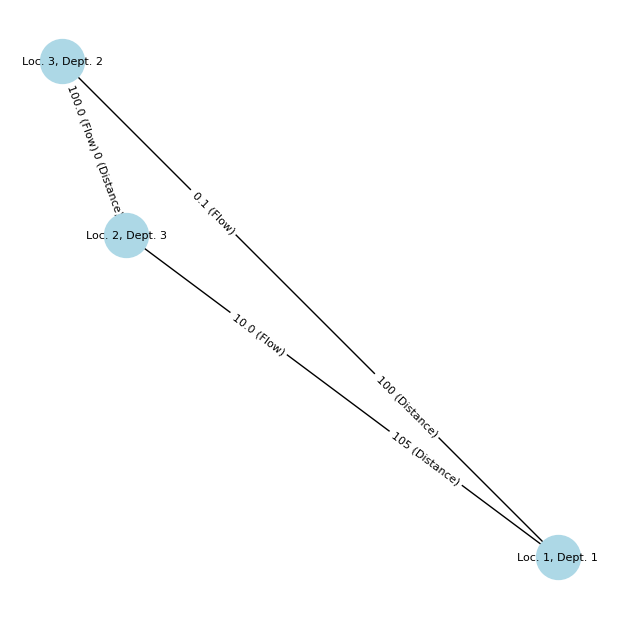

In [18]:
# display the current state as a graph
system.show_state_graph()